In [1]:
import csv
import RM_utils
import numpy as np
import res_utils
import time
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})


In [2]:
def initialize(letter_vecs, state_length=5, n_steps=500):
    N = letter_vecs.shape[1]
    D = letter_vecs.shape[0]

    states = []
    coef_hists = []

    for i in range(state_length):
        states.append(np.random.randn(N))

    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/np.linalg.norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]

    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))

    return states, coef_hists

def resonate_trigram(bound_vec, letter_vecs, state_length=5, max_steps=500):
    th_vec = bound_vec.copy()
    conseq_preds = []
    convstep = max_steps

    states, coef_hists = initialize(letter_vecs, state_length, max_steps)

    #state_length = len(states)
    N = letter_vecs.shape[1]
    D = letter_vecs.shape[0]

    for i in range(max_steps):
        all_converged = np.zeros(state_length-2)
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])

            if i > 1:
                all_converged[j-1] = np.allclose(coef_hists[j-1][i,:], coef_hists[j-1][i-1, :],
                                                 atol=5e-3, rtol=2e-2)

            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])

        if np.all(all_converged) and convstep == max_steps:
            convstep=i
            #print 'converged:', i,
            #break

        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                     th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                     np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                     th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                     np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) #+ 1.0*states[j]
            states[j] = 2.0 * (states[j] > 0) - 1
            #states[j] /= norm(states[j])

    return states, coef_hists, convstep

def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))

def diff_trigram_dict(past2, pres1, pres2, regularized=False):
    psi = np.zeros(N)
    for k in range(past2.shape[0]):
        bound_diff = pres1[k] * (past2[k]-pres2[k])
        if regularized:
            pred = psi*pres1[k] + pres2[k]
            psi += ((N-RM_utils.sim(pred, past2[k]))/float(N)) * bound_diff
        else:
            psi += bound_diff
    return psi

In [3]:
datafolder = 'data/cleaned/'
filenames = [
    'regular_verbs_clean.csv'
]
pres, past = [], []

# irregular verbs will be memorized 

In [4]:
for filename in filenames:
    with open(datafolder + filename, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] not in pres:
                pres.append(row[0])
                past.append(row[1])


In [5]:
# group by sharing trigrams
# exemplar is the first word in each group
def check_overlap(w1, w2, num_trigrams=3):
    oc = 0
    for i in range(len(w1), 0, -1):
        for j in range(len(w2), 0, -1):
            #print (w1[i-3:i], w2[j-3:j])
            if len(w1[i-3:i]) == 3 and len(w2[j-3:j]) == 3:
                if w1[i-3:i] == w2[j-3:j]:
                    oc += 1
    #print ('oc', oc)
    if oc > num_trigrams:
        return True
    return False

def append_to_group(pastverb, presverb, presgroups, pastgroups):
    for j in range(len(pastgroups)):
        #print (pastgroups[j][0], pastverb)
        if check_overlap(pastgroups[j][0], pastverb):
            presgroups[j].append(presverb)
            pastgroups[j].append(pastverb)
            return 
    presgroups.append([presverb])
    pastgroups.append([pastverb])
    return

presgroups = [[pres[0]]]
pastgroups = [[past[0]]]
for i in range(1,len(past)):
    append_to_group(past[i], pres[i], presgroups, pastgroups)

In [6]:

ctr = 0
for i in range(len(pastgroups)):
    ctr += len(pastgroups[i])
    print len(pastgroups[i])
print (len(past), ctr)

4
3
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
2
1
3
4
1
2
1
1
1
1
1
3
1
5
2
1
4
1
2
4
6
1
1
4
1
4
2
2
1
3
1
1
1
4
1
1
3
1
3
7
1
2
1
2
10
6
2
4
1
1
3
3
1
3
21
2
1
1
3
1
7
1
1
1
5
1
2
1
3
1
2
1
1
1
2
1
1
6
1
1
1
2
2
6
1
8
5
1
1
1
1
1
5
1
1
6
1
7
1
1
2
1
1
6
1
5
1
3
1
1
16
1
3
3
3
1
1
1
2
11
3
1
7
1
1
1
1
1
4
1
1
7
2
1
1
1
1
1
1
2
1
1
1
1
2
10
3
3
1
2
1
1
1
4
2
1
4
1
1
1
12
1
1
1
2
1
3
1
1
1
1
6
1
7
1
1
1
1
4
1
4
8
1
1
1
2
2
8
14
6
6
1
1
7
16
1
11
3
1
1
1
1
1
1
10
9
6
4
12
1
1
3
3
1
2
1
4
1
2
2
2
2
1
1
4
1
6
1
1
4
1
1
2
1
2
1
2
1
1
1
2
1
2
1
3
8
2
3
1
2
1
4
5
3
1
2
2
3
2
2
1
1
1
2
1
1
2
3
4
3
1
1
2
1
2
1
2
1
1
3
1
3
3
1
1
1
1
2
2
1
4
1
1
4
5
1
2
1
1
1
1
1
1
7
1
1
1
1
1
1
4
1
1
2
1
1
1
4
1
1
2
1
4
1
1
1
1
1
1
3
2
6
1
1
2
1
1
1
2
1
2
2
1
1
1
1
1
1
1
1
1
3
1
3
3
1
1
5
1
2
1
3
1
1
1
1
3
2
1
3
1
1
4
3
8
1
1
2
2
2
1
3
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
2
1
6
1
1
3
6
1
6
2
1
3
1
1
1
1
1
4
2
4
1
1
2
1
1
6
3
2
1
1
19
1
3
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
3
1
1
1
1
1


In [7]:
trainverbs, testverbs = [], []
testverbs, testverbs = [], []
for i in range(len(pastgroups)):
    if len(pastgroups[i]) > 3:
        trainverbs.append([presgroups[i][0], pastgroups[i][0]])
        trainverbs.append([presgroups[i][1], pastgroups[i][1]])
        testverbs.append([presgroups[i][2], pastgroups[i][2]])

In [8]:
with open("train.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(trainverbs)

with open("test.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(testverbs)

In [9]:
# graphing stuff
restense_files = ['res-tense-N=10000-D=28-n180503155421.npz' 
             ]
stats = {'binaccs': [], 'convbinaccs': [], 'convsteps': [], 'convbinaccs': []}
stats = {
    'trainaccs': [],
    'testaccs': [],
    'trainaccs_var': [],
    'testaccs_var': [],
    'trainconvsteps': [],
    'testconvsteps': []
}


for tf in restense_files:
    f = np.load('data/'+tf)
    stats['trainaccs'].append(list(f['trainaccs']))
    stats['testaccs'].append(list(f['testaccs']))
    stats['trainaccs_var'].append(list(f['trainaccs_var']))
    stats['testaccs_var'].append(list(f['testaccs_var']))
    stats['trainconvsteps'].append(list(f['trainconvsteps']))
    stats['testconvsteps'].append(list(f['testconvsteps']))
    
stats['trainaccs'] = np.array(stats['trainaccs'] )
stats['testaccs'] = np.array(stats['testaccs'])
stats['trainaccs_var'] = np.array(stats['trainaccs_var'])
stats['testaccs_var'] = np.array(stats['testaccs_var'])
stats['trainconvsteps'] = np.array(stats['trainconvsteps'])
stats['testconvsteps'] = np.array(stats['testconvsteps'])


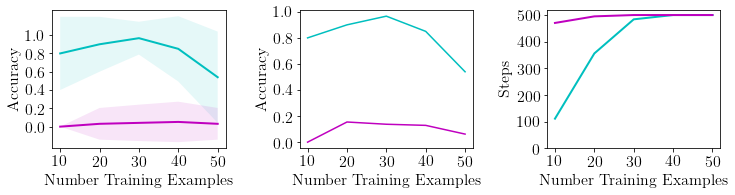

In [36]:
def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph(x, y1, y2, y1var, y2var,
          steps1, steps2,
          title=None, xlabel='Number Training Examples', ylabel='Accuracy', legend='upper left'):
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(np.sqrt(y1var)),max(np.sqrt(y2var))))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(np.sqrt(y1var)),max(np.sqrt(y2var))))
    y1std = np.clip(np.sqrt(y1var), max(-8, start-.5), min(8, end+.5))
    y2std = np.clip(np.sqrt(y2var), max(-8, start-.5), min(8, end+.5))
    
    fig, axes = plt.subplots(1, 3, sharex='all', squeeze=True, figsize=(3.5*3,3))

    axes[0].plot(x, y1, c='c', lw=2, label='Train')
    axes[0].plot(x, y2, c='m', lw=2, label='Test')

    axes[0].fill_between(x, y1-y1std, y1+y1std, facecolor='c', alpha=0.1)
    axes[0].fill_between(x, y2-y2std, y2+y2std, facecolor='m', alpha=0.1)

    rescaled_y2 = [(y2[i]*100.0)/(10.0 * float(i+1))for i in range(y2.shape[0])]
    axes[1].plot(x, y1, c='c', label='Train')
    axes[1].plot(x, rescaled_y2, c='m', label='Test')

    yticks = [.2*i for i in range(6)]
    for i in range(2):
        axes[i].set_xlabel(xlabel,fontsize=16)
        axes[i].set_ylabel(ylabel,fontsize=16)
        axes[i].set_xticks(x)
        axes[i].set_yticks(yticks)

    stepticks = [100*i for i in range(6)]
    axes[2].plot(x, steps1, c='c', lw=2, label='Train')
    axes[2].plot(x, steps2, c='m', lw=2, label='Test')
    axes[2].set_xlabel(xlabel,fontsize=16)
    axes[2].set_ylabel('Steps',fontsize=16)
    axes[2].set_xticks(x)
    axes[2].set_yticks(stepticks)
    
    for i in range(3):
        for tick in axes[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axes[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
            
    plt.tight_layout()
    
x = [10*(i+1) for i in range(5)]

graph(x, stats['trainaccs'][0], stats['testaccs'][0], 
      stats['trainaccs_var'][0], stats['testaccs_var'][0],
      stats['trainconvsteps'][0], stats['testconvsteps'][0]
     )

In [17]:
y1 = stats['trainaccs']
y2 = stats['testaccs']
print y1.shape
print (min(y1), min(y2))
print min(min(y1), min(y2)) - max(max(y1std),max(y2std))

(1, 5)
(array([ 0.8       ,  0.9       ,  0.96666667,  0.85      ,  0.54      ]), array([ 0.        ,  0.03092784,  0.04123711,  0.05154639,  0.03092784]))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# running stuff

In [8]:
def encode(verbs, N, dic1, dic2, alph):
    pres1 = np.zeros((len(verbs), N))
    pres2 = np.zeros((len(verbs), N))
    past1 = np.zeros((len(verbs), N))
    past2 = np.zeros((len(verbs), N))

    for m in range(len(verbs)):
        pres1[m] = RM_utils.ngram_encode_cl(verbs[m][0], dic1, alph)
        pres2[m] = RM_utils.ngram_encode_cl(verbs[m][0], dic2, alph)
        past1[m] = RM_utils.ngram_encode_cl(verbs[m][1], dic1, alph)
        past2[m] = RM_utils.ngram_encode_cl(verbs[m][1], dic2, alph)
    return pres1, pres2, past1, past2
    
alph = 'abcdefghijklmnopqrstuvwxyz#.'
D = len(alph)
N = 100000

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

trainpres1, trainpres2, trainpast1, trainpast2 = encode(trainverbs, N, dic1, dic2, alph)
testpres1, testpres2, testpast1, testpast2 = encode(testverbs, N, dic1, dic2, alph)


In [9]:
print len(trainverbs)

194


In [ ]:
trainaccs = []
testaccs = []
trainaccs_var = []
testaccs_var = []
sized_testaccs_var = []
trainconvsteps = []
testconvsteps = []
sized_testconvsteps = []

In [ ]:
for i in range(10,len(trainverbs),10):
    print ('i', i)
    diff_psi = diff_trigram_dict(trainpast2[:i],
                                 trainpres1[:i],
                                 trainpres2[:i],
                                 True
                                )
    
    pred_vecs = trainpres1[:i] * diff_psi + trainpres2[:i]
    test_pred_vecs = testpres1 * diff_psi + testpres2
    
    trainacc = np.zeros(i)
    trainavg_steps = np.zeros(i)
    print ('train')
    for j in range(i):  
        states, coef_hists, convstep = resonate_trigram(pred_vecs[j], dic2, len(trainverbs[j][1])+2)
        pred, alphis = res_utils.spell(coef_hists)
        print (pred, trainverbs[j][1])
        trainacc[j] = 1 if pred == trainverbs[j][1] else 0
        trainavg_steps[j] = convstep
#         print (pred, trainverbs[j][1])
    
    testacc = np.zeros(len(testverbs))
    testavg_steps = np.zeros(len(testverbs))
    print ('test')
    for j in range(len(testverbs)): 
        states, coef_hists, convstep = resonate_trigram(test_pred_vecs[j], dic2, len(testverbs[j][1])+2)
        pred, alphis = res_utils.spell(coef_hists)
        print (pred, testverbs[j][1])
        testacc[j] = 1 if pred == testverbs[j][1] else 0
        testavg_steps[j] = convstep
#         print (pred, trainverbs[j][1])
    
    trainaccs.append(np.average(trainacc))
    testaccs.append(np.average(testacc))
    trainaccs_var.append(np.var(trainacc))
    testaccs_var.append(np.var(testacc))
    sized_testaccs_var.append(np.var(testacc[:i//2]))
    trainconvsteps.append(np.average(trainavg_steps))
    testconvsteps.append(np.average(testavg_steps))
    sized_testconvsteps.append(np.average(testavg_steps[:i//2]))
    
    fname = ('data/res-tense-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

    np.savez(fname, trainaccs=trainaccs, 
             testaccs=testaccs,
             trainaccs_var=trainaccs_var,
             testaccs_var=testaccs_var,
             trainconvsteps=trainconvsteps,
             testconvsteps=testconvsteps,
             sized_testaccs_var=sized_testaccs_var,
             sized_testconvsteps=sized_testconvsteps,
             N=N, D=D)


In [ ]:
fname = ('data/res-tense-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, trainaccs=trainaccs, 
         testaccs=testaccs,
         trainaccs_var=trainaccs_var,
         testaccs_var=testaccs_var,
         trainconvsteps=trainconvsteps,
         testconvsteps=testconvsteps,
         sized_testaccs_var=sized_testaccs_var,
         sized_testconvsteps=sized_testconvsteps,
         N=N, D=D)

In [ ]:
print (trainaccs, testaccs, trainaccs_var) #regularization 

In [33]:
print (trainaccs, testaccs) #no regularization 

([0.90000000000000002], [0.0])


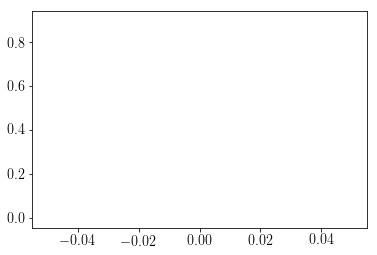

In [31]:
plt.figure()
plt.plot(trainaccs)
plt.plot(testaccs)
plt.show()

In [13]:
diff_psi = diff_trigram_dict(trainpast2, trainpres1, trainpres2)
pred_vec = trainpres1 * diff_psi + trainpres2
print pred_vec.shape

(102, 10000)


In [74]:
# group by similarity
alph = 'abcdefghijklmnopqrstuvwxyz#.'
N = 1000
D = len(alph)
dic1 = 2 * (np.random.randn(D, N) < 0) - 1
cutoff = 150

In [75]:
def check_sim(w1, w2, cutoff, dic, alph):
    wv1 = RM_utils.ngram_encode_cl(w1, dic, alph)
    wv2 = RM_utils.ngram_encode_cl(w2, dic, alph)
    if np.dot(wv1, wv2) > cutoff:
        return True
    return False

# exemplar is the first word in each group
def append_to_group(pastverb, presverb, presgroups, pastgroups, cutoff, dic, alph):
    for j in range(len(pastgroups)):
        if check_sim(pastgroups[j][0], pastverb, cutoff, dic, alph):
            presgroups[j].append(presverb)
            pastgroups[j].append(pastverb)
            return 
    presgroups.append([presverb])
    pastgroups.append([pastverb])
    return

presgroups = [[pres[0]]]
pastgroups = [[past[0]]]
for i in range(1,len(past)):
    append_to_group(past[i], pres[i], presgroups, pastgroups, cutoff, dic1, alph)
    


In [76]:
for i in range(len(pastgroups)):
    print len(pastgroups[i])

356
227
83
148
7
9
12
4
11
7
12
9
13
13
155
8
5
111
62
4
45
8
3
5
12
140
7
10
107
37
6
49
85
5
28
103
3
88
36
51
5
78
2
4
3
4
26
2
2
1
13
6
4
33
5
4
2
3
34
16
5
1
3
1
3
19
6
2
3
1
1
1
9
2
1
2
2
2
2
2
1
2
5
2
1
1
4
4
2
3
1
2
4
1
1
2
1
1
3
1
1
1
1
2
1
1
1
1
2
1


In [77]:
print len(pastgroups)

110
